In [1]:
import pandas as pd
import numpy as np
import datetime
import itertools
from numba import njit
import csv
import pickle
import matplotlib.pyplot as plt

## Location for downloaded data files other input files:

In [2]:
#CHANGE TO YOUR DIRECTORY_NAME:
HOSPITAL_LOC = "/DIRECTORY_NAME/Densification_proj/Dataset/Hospitaldataset.csv"
IC2S2_LOC = "/DIRECTORY_NAME/Densification_proj/Dataset/IC2S2dataset.csv"
WS16_LOC = "/DIRECTORY_NAME/Densification_proj/Dataset/WS16dataset.csv"

PARCOMBS_LOC = "/DIRECTORY_NAME/Densification_proj/parameter_combinations/paramcombs.csv"
WORKPLACE_PARCOMBS_LOC = "/DIRECTORY_NAME/Densification_proj/parameter_combinations/paramcombs_workplace.csv"

LKFNS_LOC = "/DIRECTORY_NAME/Densification_proj/likelihoodfns/Likefn"
WORKPLACE_LKFNS_LOC = "/DIRECTORY_NAME/Densification_proj/likelihoodfns_workplace/Likefn"

## User imports the datasets

In [39]:
#Hospital data: December 7, 2010
Hospitaldata = pd.read_csv(HOSPITAL_LOC)

Hospitalseq = Hospitaldata.values

In [87]:
Hospitaldata.head()

,N,M
0,6,4
1,8,8
2,10,15
3,14,17
4,17,21


In [40]:
#International Conference on Computational Science data: July 11, 2017
IC17data = pd.read_csv(IC2S2_LOC)
IC17seq = IC17data.values

In [84]:
IC17data.head()

,N,M
0,26,45
1,27,34
2,31,44
3,41,67
4,47,95


In [42]:
#Winter School data: December 1, 2016
WS16data = pd.read_csv(WS16_LOC)
WS16seq = WS16data.values

In [86]:
WS16data.head()

,N,M
0,39,92
1,41,68
2,24,22
3,27,23
4,32,27


## Load Parameter combinations & Likelihood Fns used to obatin the estimates

In [7]:
#1 User imports the Dictionary of parameter combinations. Format - ID: (kappa, Np)
parcombs = pd.read_csv(PARCOMBS_LOC)
parcombs_dict = parcombs.set_index("id").T.to_dict("list")
parcombs2 = {key:tuple(values) for key, values in parcombs_dict.items()}

In [8]:
#2 User imports the likelihood functions
Likelihoodfns = {}
for combs in parcombs2:
    df = pd.read_pickle(LKFNS_LOC+combs)
    Likelihoodfns[combs] = df[["N","M","prob"]].values



# Implement the maximum-likelihood estimation

### Maximum-likelihood estimation function

In [43]:
class MLestimation:
    # Input: Sequence of triplets (i.e., NM) consisting of time (t), total active nodes (N) and total edges (M).
    def __init__(self, NM):
        self.NM = NM
        self.PARAMS = parcombs2
        self.LKFNS  = Likelihoodfns
    
    @staticmethod
    @njit(nopython=True)  
    def prob_func(A,E,likelihood):
        probindex = np.where((likelihood[0:,0]==A) & (likelihood[0:,1]==E))
        if probindex[0].size!=0:
            probability = likelihood[probindex][0,-1]
        return probability
    
    def MLE(self):
        """
        Input.

        NMseq: Sequence of triplets consisting of time (t), total active nodes (N) and total edges (M).

        Output. 
        Estimates of overall act and pop size: kappa and Np. Type: (pandas.DataFrame)
        """
        
        knp_ests = []
        for elem in self.NM:
            N,M = elem
            prob_NM = []
            combid = []
            for fid,LF in self.LKFNS.items():
                prob_NM.append(self.prob_func(N,M,LF))
                combid.append(fid)
            estparam_index = np.argmax(np.asarray(prob_NM))
            estparams_id = combid[estparam_index]
            knp_ests.append( estparams_id)
            
        estimates = pd.DataFrame({"params":knp_ests})
        kappavalues, npvalues = self.estimators(estimates)
        estimates["kappa"] = kappavalues
        estimates["np"] = npvalues
        return estimates

    @staticmethod
    def estimators(estimates):
        PARAMS = parcombs2
        """
        Input: Helper that takes sequences of IDs for (kappa, Np) combinations which have been
        identified as estimators by the MLE instance above.

        Output: DataFrame of estimates kappa_hat and Np_hat given a time window t

        The function matches the ids of the parameter combination (i.e, PARAMS) with the ML
        estimators (kappa_hat and Np_hat).
        """
        kappa_seq = []
        np_seq = []
        for combs in estimates["params"]:
            kappa,np = PARAMS[combs]
            kappa_seq.append(kappa)
            np_seq.append(np)
        return kappa_seq,np_seq
 
    

# Result: Estimated activity and population size for the datasets

### Hospital

In [10]:
Hospitaldailyestimates = MLestimation(Hospitalseq).MLE()

In [79]:
Hospitaldailyestimates.head()

,params,kappa,np
0,p2072,0.225,13.0
1,p6878,0.750,10.0
2,p12375,1.350,11.0
3,p5283,0.575,18.0
4,p3683,0.400,21.0


### IC2S2-17

In [64]:
IC2S2dailyestimates = MLestimation(IC17seq).MLE()

In [80]:
IC2S2dailyestimates.head()

,params,kappa,np
0,p3921,0.425,30.0
1,p2323,0.250,35.0
2,p2326,0.250,38.0
3,p2337,0.250,49.0
4,p2572,0.275,55.0


### WS-16

In [65]:
WSdailyestimates = MLestimation(WS16seq).MLE()

In [81]:
WSdailyestimates.head()

,params,kappa,np
0,p3934,0.425,43.0
1,p2337,0.250,49.0
2,p955,0.100,41.0
3,p958,0.100,44.0
4,p738,0.075,53.0


# Plot figures for estimates

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

### Estimated $\kappa$

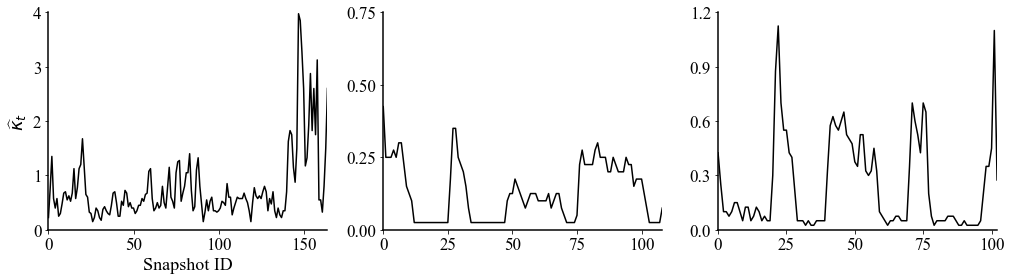

In [82]:
fig,(ax1,ax3,ax4) = plt.subplots(1,3,figsize = (17,4))
ax1.set_ylim(0,4)
ax3.set_ylim(0,0.75)
ax3.set_yticks(np.arange(0,0.8,0.25))
ax4.set_ylim(0,1.2)
ax4.set_yticks(np.arange(0,1.5,0.3))

ax1.set_xlim(0,Hospitaldailyestimates.index[-1])
ax3.set_xlim(0,IC2S2dailyestimates.index[-1])
ax4.set_xlim(0,WSdailyestimates.index[-1])

ax1.set_xlabel("Snapshot ID",fontsize=18)
ax1.set_ylabel("$\widehat{{\kappa}}_t$",fontsize=18)

#PLOT ESTIMATES OF KAPPA
ax1.plot(Hospitaldailyestimates.index,Hospitaldailyestimates["kappa"],"k-")
ax3.plot(IC2S2dailyestimates.index,IC2S2dailyestimates["kappa"],"k-")
ax4.plot(WSdailyestimates.index,WSdailyestimates["kappa"],"k-")

#_______plot format_______________________________
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

#___________________________________________________
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams["axes.linewidth"] = 1.5
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('xtick',labelsize=17)
plt.rc('ytick',labelsize=17)

### Estimated population size $N_{\mathrm{p},t}$

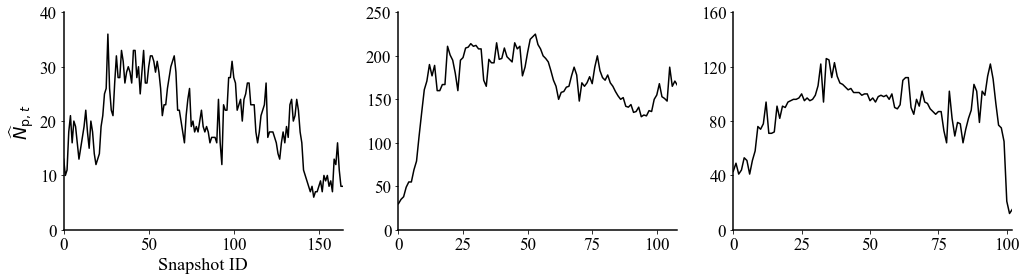

In [83]:
fig,((ax1,ax3,ax4)) = plt.subplots(1,3,figsize = (17,4))
ax1.set_ylim(0,40)
ax1.set_yticks(np.arange(0,50,10))
ax3.set_ylim(0,250)
ax3.set_yticks(np.arange(0,300,50))
ax4.set_ylim(0,160)
ax4.set_yticks(np.arange(0,200,40))


ax1.set_xlim(0,Hospitaldailyestimates.index[-1])
ax3.set_xlim(0,IC2S2dailyestimates.index[-1])
ax4.set_xlim(0,WSdailyestimates.index[-1])

ax1.set_xlabel("Snapshot ID",fontsize=18)
ax1.set_ylabel("$\widehat{{N}}_{\mathrm{p},t}$",fontsize=18)

#PLOT ESTIMATES OF POP.SIZE
ax1.plot(Hospitaldailyestimates.index,Hospitaldailyestimates["np"],"k-")
ax3.plot(IC2S2dailyestimates.index,IC2S2dailyestimates["np"],"k-")
ax4.plot(WSdailyestimates.index,WSdailyestimates["np"],"k-")

#_______plot format_______________________________
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)